In [1]:
import numpy as np
import scipy as sc
from scipy import integrate
import sympy as sp
from src.data_generation import (
    calc_dim_tab,
    get_tensor_basis,
    tag_func,
    get_kinetic_H_vw,
)
import matplotlib.pyplot as plt
from numba.typed import List, Dict
import seaborn as sns

Model parameters

In [2]:
M = 6
N = np.array([1])
J = 1
component_count = 1
# Statistic (bose/fermi)
stat_vec = np.array(["f"])
vv_tab = np.linspace(0.002, 2.002, 200)
D = calc_dim_tab(M, N, stat_tab=['f'])

vv = 0.5
ww = 1
vw_tab = np.array([vv, ww])

W_disorder_tab = np.array([0.0, 0.0])

# Periodic boundary conditions
pbc = 1

Generation of Fock basis

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]]


<AxesSubplot:>

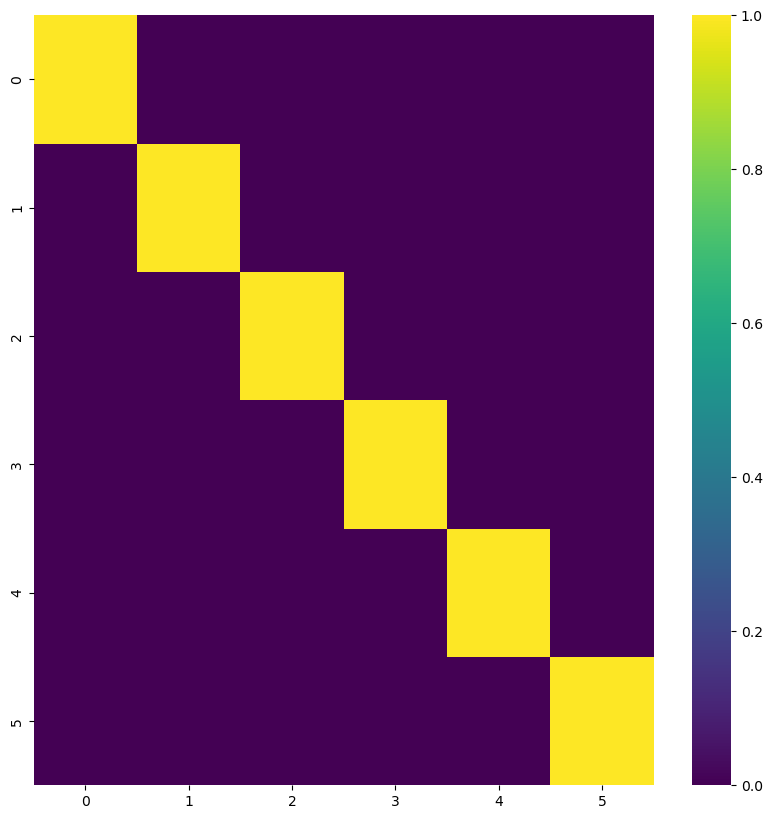

In [3]:
A = get_tensor_basis(
                    M, N, statistic=stat_vec, component_count=component_count, verb=0
                )
print(A[:3])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(A, ax=ax, cmap="viridis")

Hashing the basis for more efficient search and indexing

In [4]:
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()

for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

Constructing Hamiltonian

In [5]:
H_hop_1 = [List(), List(), List()]
H_hop_1 = get_kinetic_H_vw(
    A,
    M,
    J,
    t_dict,
    vw=vw_tab,
    disord_W=W_disorder_tab,
    pbc=pbc,
    statistic=stat_vec[0],
    component_count=component_count,
    component_no=0,
)
H_hop_1 = sc.sparse.coo_matrix(
    (H_hop_1[0], (H_hop_1[1], H_hop_1[2])), shape=(D, D)
)

H_hop_1 = sc.sparse.triu(H_hop_1)

H_hop_1 = (
    H_hop_1
    + H_hop_1.T
    - sc.sparse.diags(H_hop_1.diagonal(), format="coo")
)

H_1 = J * H_hop_1

H_tot = H_1

H_dense = H_tot.toarray()

Let's have a look at the Hamiltonian

<AxesSubplot:>

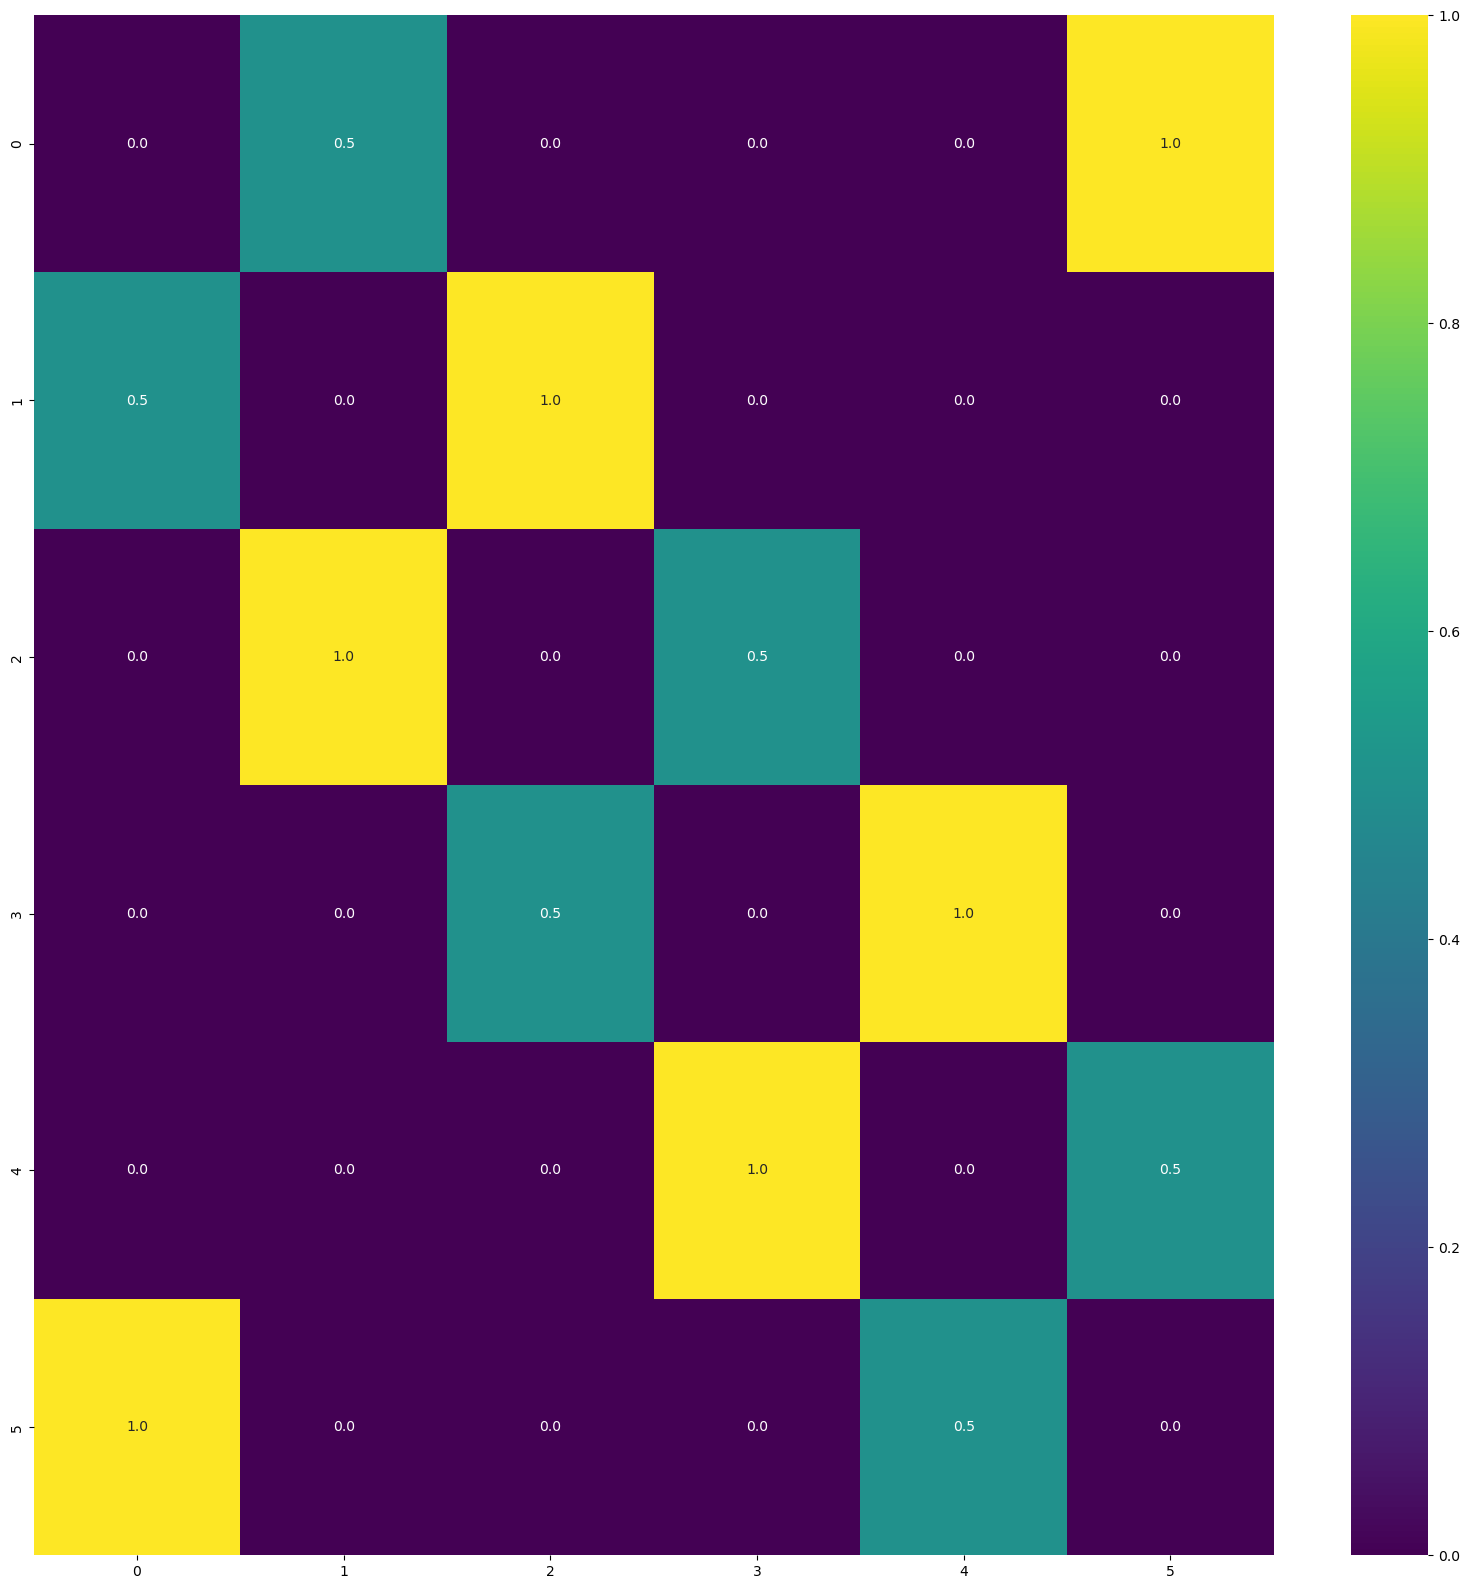

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(H_dense, ax=ax, cmap="viridis", annot=True, fmt=".1f")

We need to construct the chiral symmetry operator

In [7]:
dvec = np.array(
    [
        (lambda snum: 1 if snum % 2 == 0 else -1)(snum)
        for snum in range(M)
    ]
)

dvec

array([ 1, -1,  1, -1,  1, -1])

In [8]:
chiral = sc.sparse.coo_matrix(sc.sparse.diags(dvec))

ch_evals, ch_evecs = np.linalg.eigh(chiral.toarray())

We get the eigenbasis of the chiral operator for further transformation of the Hamiltonian

In [9]:
sp.Matrix(chiral.toarray())

Matrix([
[1.0,    0,   0,    0,   0,    0],
[  0, -1.0,   0,    0,   0,    0],
[  0,    0, 1.0,    0,   0,    0],
[  0,    0,   0, -1.0,   0,    0],
[  0,    0,   0,    0, 1.0,    0],
[  0,    0,   0,    0,   0, -1.0]])

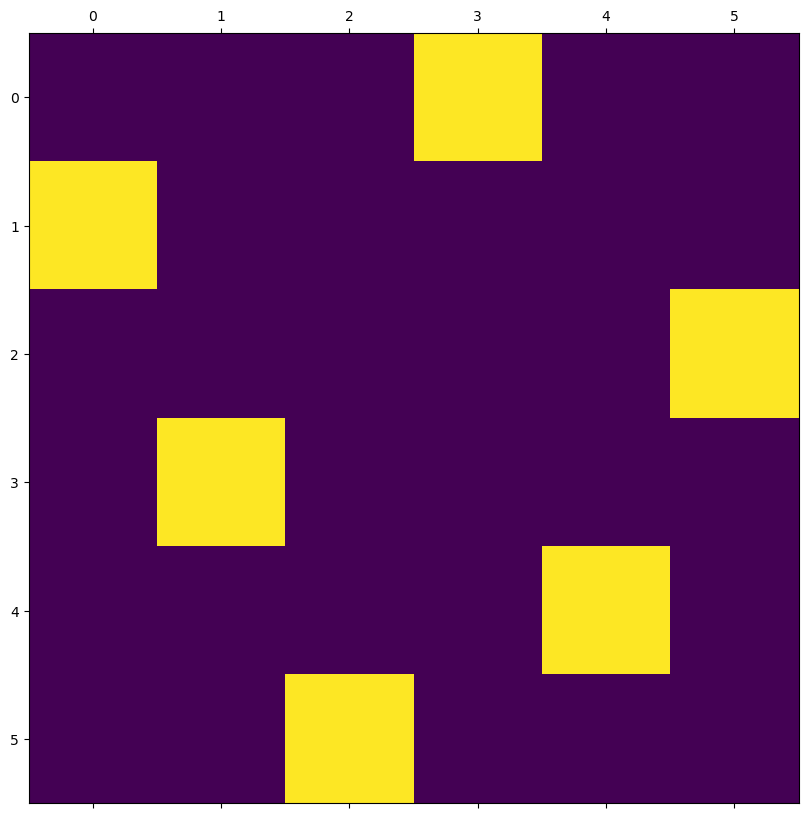

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(ch_evecs, cmap="viridis")

In [11]:
sorted_evecs = np.zeros(shape=(D, D))
sorted_evals = np.zeros(shape=(D,))

for num, i in enumerate(
    np.repeat(
        np.linspace(0, D // 2, D // 2, endpoint=False, dtype=np.int64),
        2,
    )
):
    rownum = np.where(ch_evecs[:, -(num + 1)] == 1)[0][0]
    fact = 0 if num % 2 == 0 else int(D / 2)
    new_rownum = fact + i
    new_row = ch_evecs[rownum].copy()
    sorted_evecs[new_rownum] = new_row
    sorted_evals[new_rownum] = ch_evals[rownum].copy()

ch_evecs = sorted_evecs
ch_evals = sorted_evals

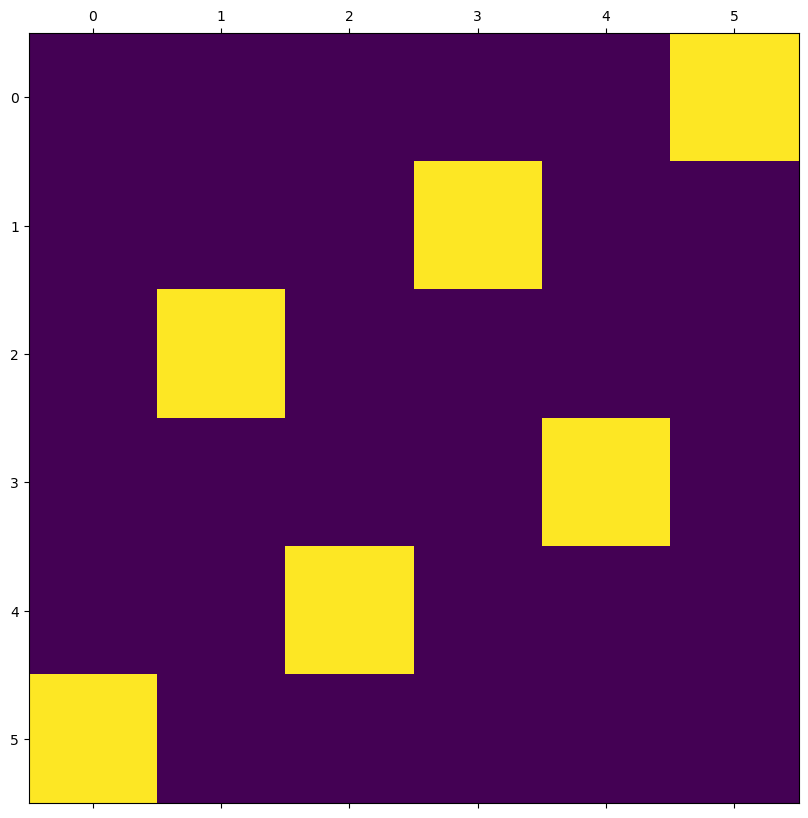

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(ch_evecs, cmap="viridis")

Now we transform the Hamiltonian into the chiral eigenbasis

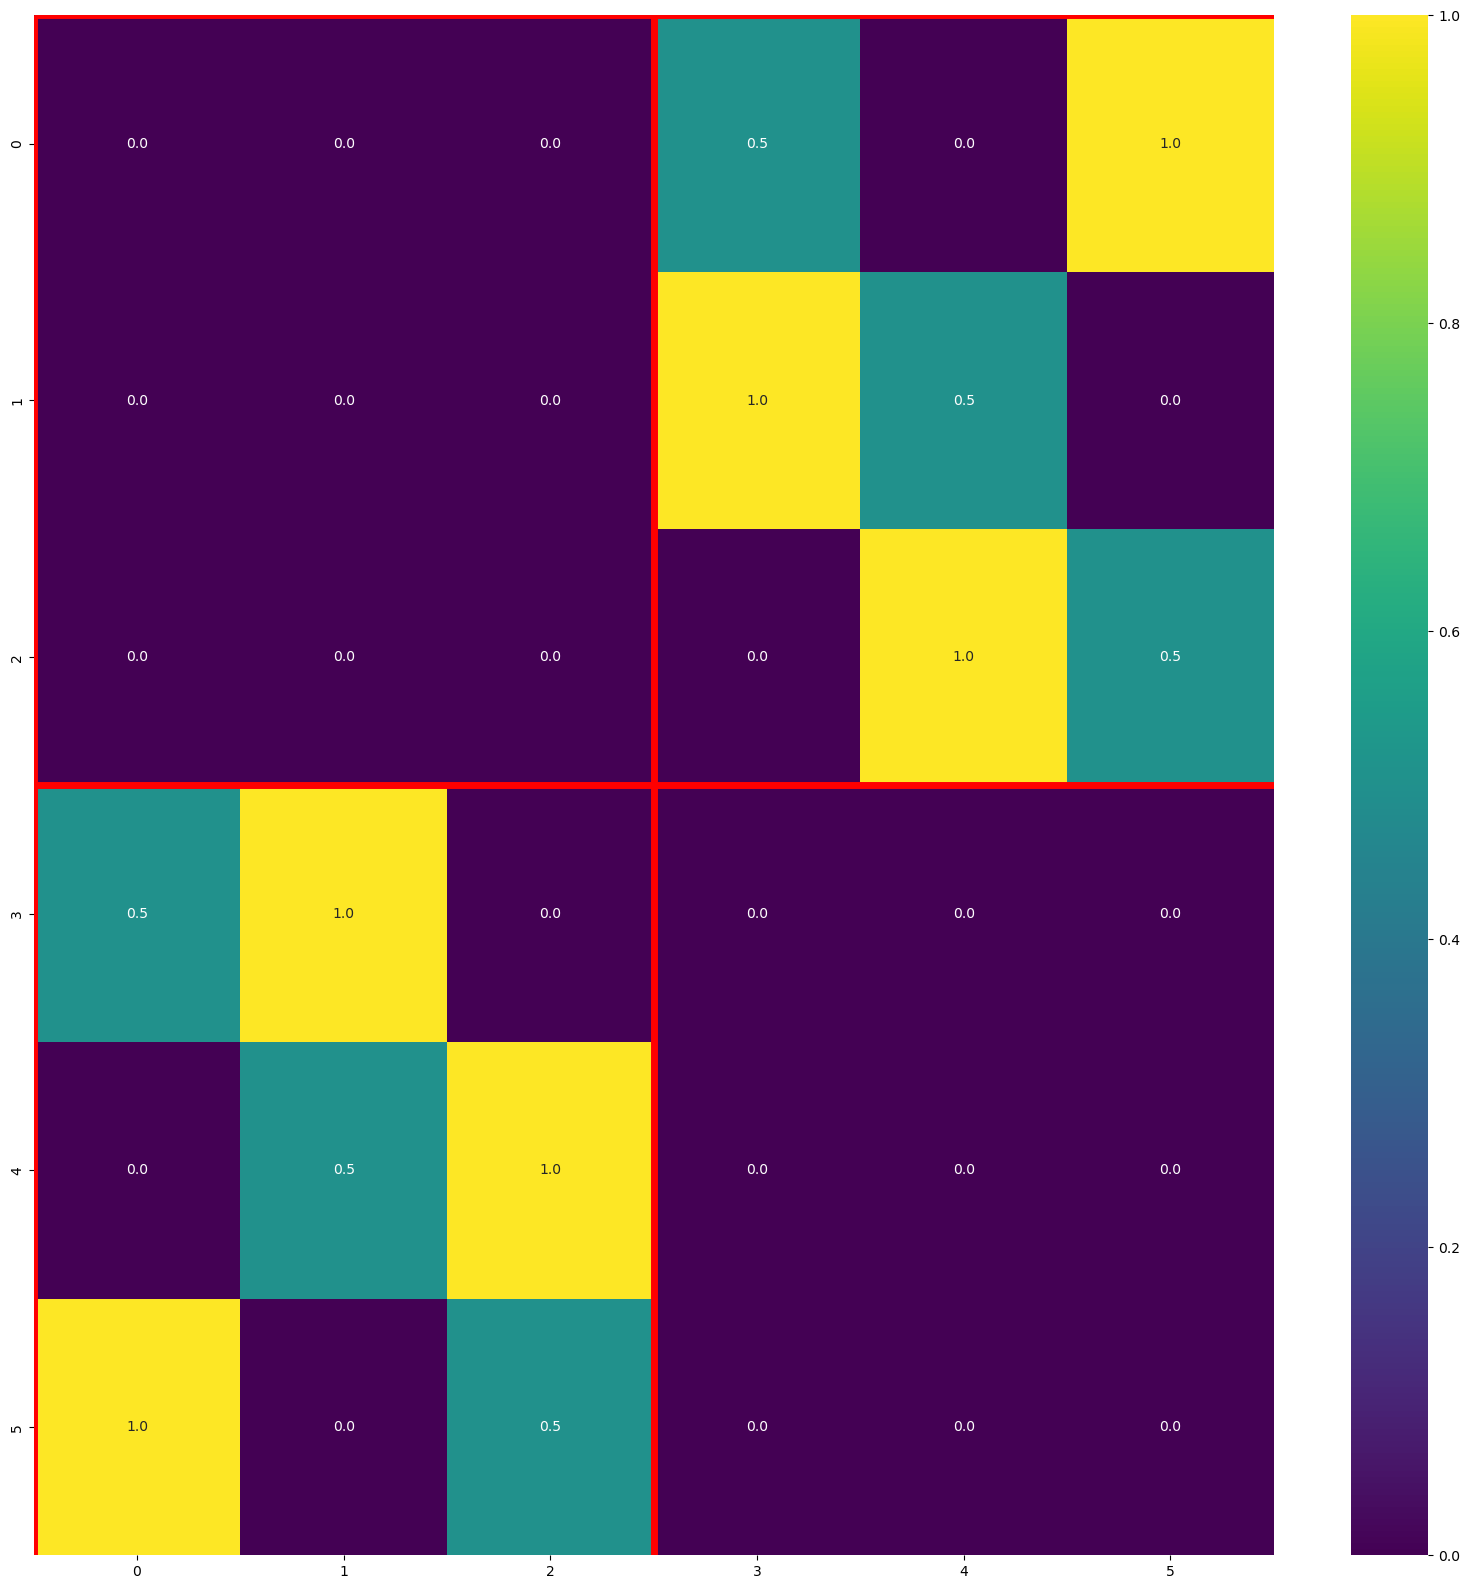

In [13]:
H_new_basis = ch_evecs @ H_dense @ (np.linalg.inv(ch_evecs))
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(H_new_basis, ax=ax, cmap="viridis", annot=True, fmt=".1f")
ax.vlines(
    np.linspace(0, D, N[0] + 1, endpoint=False),
    *ax.get_ylim(),
    colors="r",
    linewidth=5,
)
ax.hlines(
    np.linspace(0, D, N[0] + 1, endpoint=False),
    *ax.get_xlim(),
    colors="r",
    linewidth=5,
);

Now the structure of our Hamiltonian is:
$$ \hat{H} = \left( \begin{matrix} 0 & h \\ h^\dagger & 0 \end{matrix}\right)$$
Since for our equation for winding number we only need the off-diagonal block, we will take $h^\dagger$ and denote is as $u$

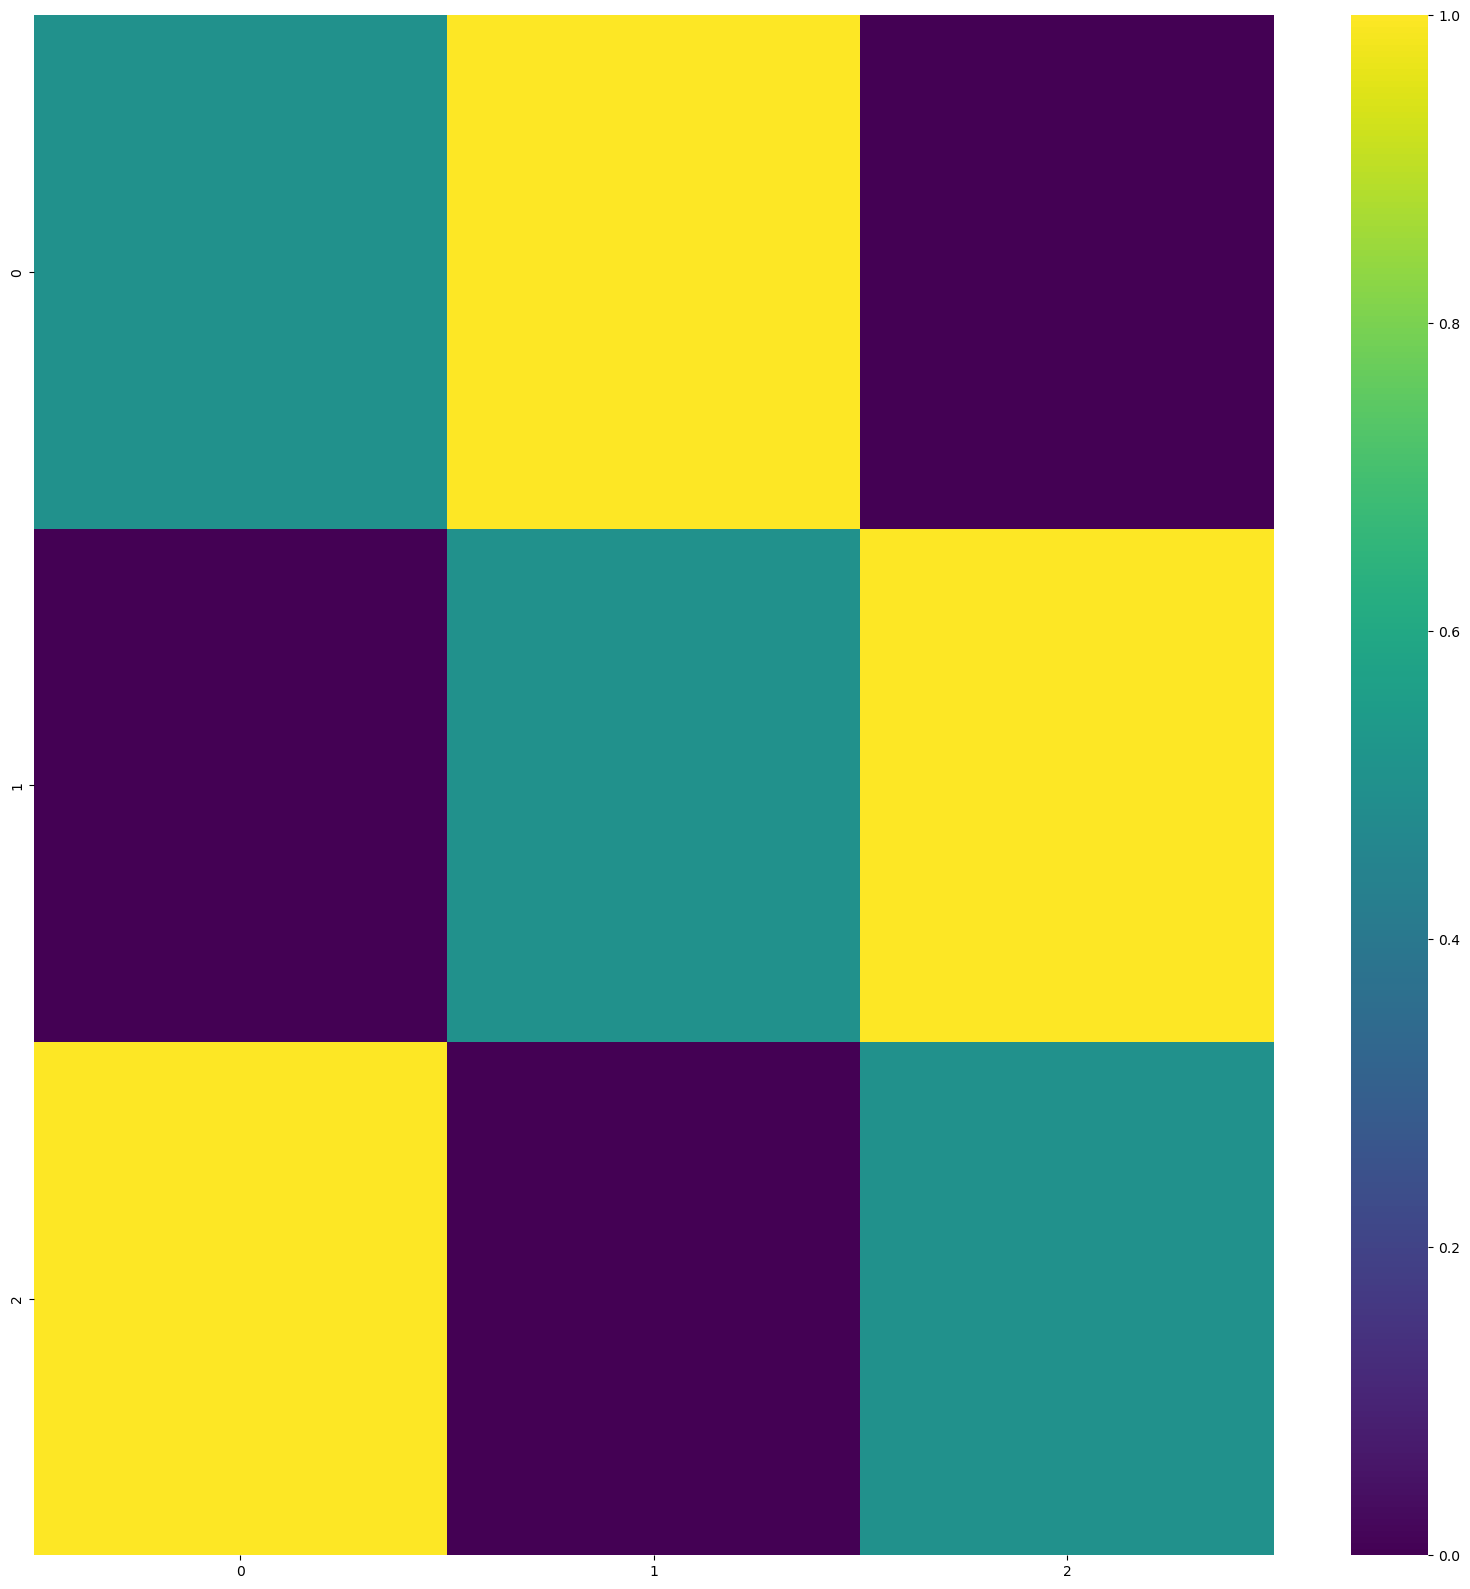

In [14]:
u = H_new_basis[D // 2 :, : D // 2]
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(u, ax=ax, cmap="viridis");

We then multiply the corner element by phase factor, that we gain once we hop from the end of our system to the beggining.  
We have now achieved the momentum space hamiltonian.

In [15]:
v, w, k = sp.symbols("v w k", real=True)

u = sp.Matrix(u)

u[-1, 0] = u[-1, 0] * sp.exp(sp.I * k)
u

Matrix([
[         0.5, 1.0,   0],
[           0, 0.5, 1.0],
[1.0*exp(I*k),   0, 0.5]])

Derivative wrt $k$

In [16]:
dkh = sp.simplify(sp.Derivative(u, k).doit())
dkh

Matrix([
[             0, 0, 0],
[             0, 0, 0],
[1.0*I*exp(I*k), 0, 0]])

And inverse of $h^\dagger$

In [17]:
u_nice = u.subs([(1.0, w), (0.5, v)])
hinv_nice = sp.Inverse(u_nice).doit()
hinv_nice


Matrix([
[         v**2/(v**3 + w**3*exp(I*k)),          -v*w/(v**3 + w**3*exp(I*k)), w**2/(v**3 + w**3*exp(I*k))],
[w**2*exp(I*k)/(v**3 + w**3*exp(I*k)),          v**2/(v**3 + w**3*exp(I*k)), -v*w/(v**3 + w**3*exp(I*k))],
[-v*w*exp(I*k)/(v**3 + w**3*exp(I*k)), w**2*exp(I*k)/(v**3 + w**3*exp(I*k)), v**2/(v**3 + w**3*exp(I*k))]])

In [18]:
hinv = sp.Inverse(u).doit()

Now we want to utilize the equation for winding number in the form:  
$$ \vartheta= \frac{1}{2 \pi i} \oint \mathrm{Tr}(h^{-1} \partial_k h)$$

In [19]:
h1_fin_nice = hinv_nice @ dkh
h1_fin_nice

Matrix([
[1.0*I*w**2*exp(I*k)/(v**3 + w**3*exp(I*k)), 0, 0],
[-1.0*I*v*w*exp(I*k)/(v**3 + w**3*exp(I*k)), 0, 0],
[1.0*I*v**2*exp(I*k)/(v**3 + w**3*exp(I*k)), 0, 0]])

In [20]:
sp.simplify(sp.Derivative(sp.log(v+w*sp.exp(sp.I*k)), k).doit())

I*w*exp(I*k)/(v + w*exp(I*k))

In [21]:
h1_fin = hinv @ dkh
expr1 = sp.Trace(h1_fin).doit() / (2 * sp.pi * sp.I)

All that is to be done now is to integrate it. For stability reasons, we perform a numeric integration here, up until $\epsilon$ from the end of the 1st Brillouin zone

In [22]:
integrand1 = sp.lambdify(k, expr1.doit(), "scipy")

r1, r1err = integrate.quad(
    integrand1, -np.pi, np.pi - np.finfo(float).eps
)

/Users/k4cp3rskiii/miniforge3/envs/ML_Pytorch/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


Et voila, we have obtained the winding number

In [23]:
print(f"Winding number is equal {round(r1)}")

Winding number is equal 1


Using this code we could also calculate winding numbers for various disordered datasets, and recreate Fig. 6. Alternatively, you can download generated data from Zenodo.

In [24]:
from src.utils import recreate_fig_6
from pathlib import Path
save_path = Path("./00_demonstrations_data/figures/")
data_path = Path("./00_demonstrations_data/datasets/")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%reload_ext autoreload
%autoreload 2
%aimport src.utils

I*log(-v**2/w**2 - 1)/(2*pi) - I*log(-v**2/w**2 + exp(I*(-2.22044604925031e-16 + pi)))/(2*pi)
I*log(v/w - 1)/(2*pi) - I*log(v/w + exp(I*(-2.22044604925031e-16 + pi)))/(2*pi)


/Users/k4cp3rskiii/miniforge3/envs/ML_Pytorch/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


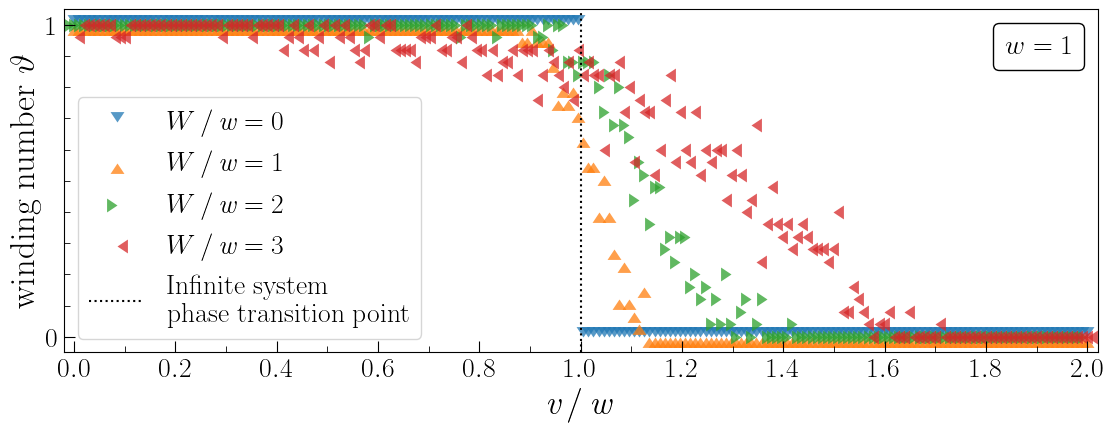

In [26]:
recreate_fig_6(save_path, data_path)